# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er ennærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [178]:
# Importer resten av pakkene du trenger her:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

In [180]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett1.csv")
# Her deler jeg datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
# PS: Ikke endre denne kodecellen!

#### Oppgave 1.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? 

Begrunn svaret

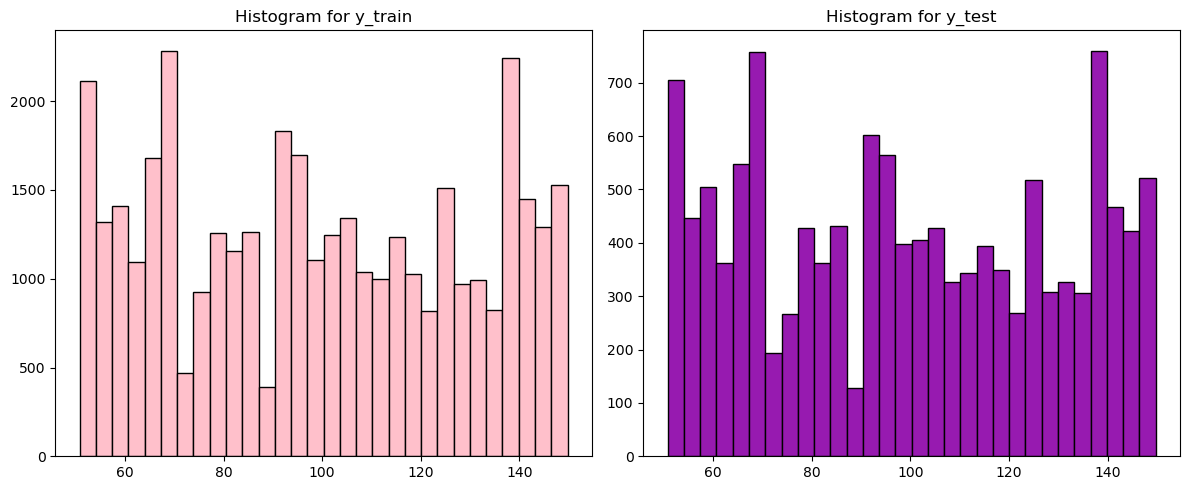

In [183]:
# Visualiser y_train og y_test i histogrammer
plt.figure(figsize=(12, 5))

# Histogram for y_train
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, color='pink', edgecolor="black")
plt.title("Histogram for y_train")

# Histogram for y_test
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=30, color='#971ab0', edgecolor="black")
plt.title("Histogram for y_test")

plt.tight_layout()
plt.show()

**Svar:**

Basert på figurene, kan man se at dette er et regresjonsproblem. Man ser at stolpene varierer jevnt over hele figuren, altså det er en fordeling av kontinuerlige verdier uten distinkte klasser.

#### Oppgave 1.2) 

fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).

* Beskriv hvilke egenskaper du ser korrelerer mest med target

In [187]:
# Funksjon for å lage og vise en korrelasjonsmatrise
def korrelasjonsmatrise(X, y):
    X_temp = X.copy()
    X_temp["Target"] = y
    
    # Beregn korrelasjonsmatrisen
    corr_matrix = X_temp.corr()
    
    # Plotte korrelasjonsmatrisen
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Korrelasjonsmatrise")
    plt.show()

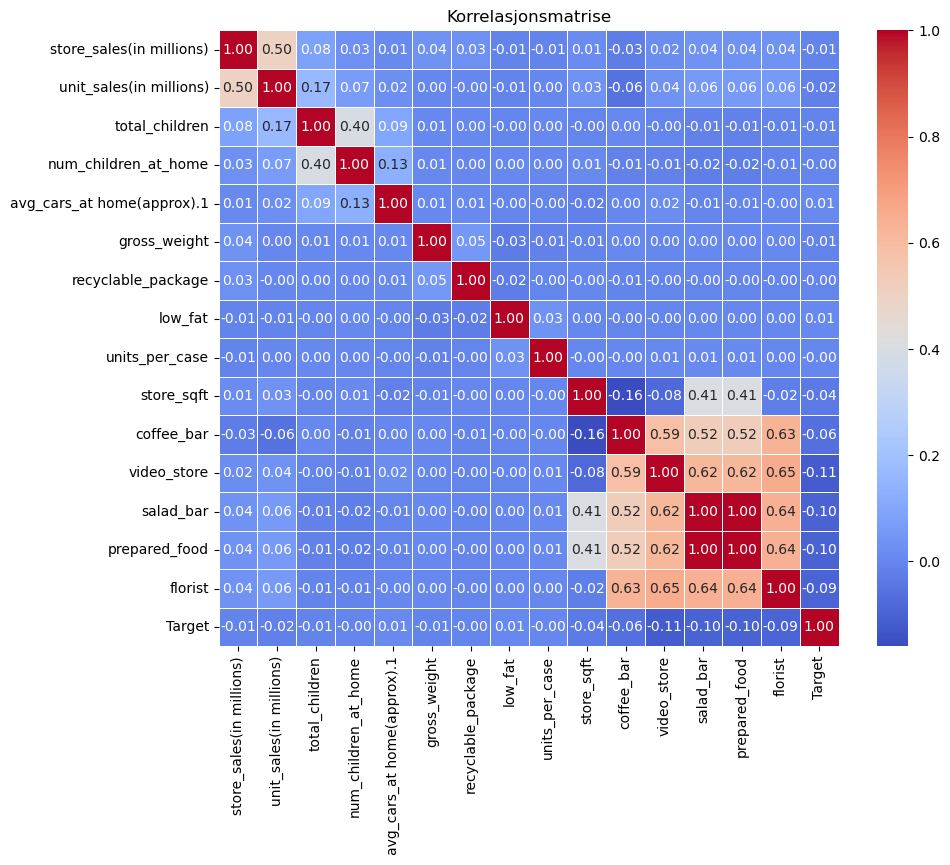

In [189]:
korrelasjonsmatrise(X_train,y_train)

**Svar:**
Man kan se at det er egenskapene prepared_food, florist, salad_bar, og video_store som korrelerer mest med target. Alle disse er ganske svake korrelasjoner.

#### Oppgave 1.3) 
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 paramtere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [193]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialiser DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=0)

# Konfigurer GridSearchCV med 3-fold kryssvalidering og "neg_mean_squared_error"
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

# Kjører grid-søket på treningsdataene
grid_search.fit(X_train, y_train)

# Henter de beste parameterne og scoren
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Beste parametere:", best_params)
print("Beste score:", best_score)



Beste parametere: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Beste score: -855.874456129783


**Svar:**

Resultatet ble at den beste parameterkombinasjonen ga en neg_mean_squared_error på -855. Dette indikerer at modellen ikke predikerer målverdiene veldig presist, med tanke på at den beste verdien for MSE er 0.

#### Oppgave 1.4) 
Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5 
* Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
* Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene? 

In [197]:
# Beste parameterne
best_params = {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1} 

# Bruker DecisionTreeRegressor med de beste parameterne
best_model = DecisionTreeRegressor(**best_params, random_state=0)

# Sett opp scoring for både MAE og MSE
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error)
}

# Utfør kryssvalidering med 5-folds
cv_results = cross_validate(best_model, X_train, y_train, cv=5, scoring=scoring)

# Logger resultatene for MAE og MSE
mae_scores = cv_results['test_MAE']
mse_scores = cv_results['test_MSE']

print("MAE-scorer for hver fold:", mae_scores)
print("MSE-scorer for hver fold:", mse_scores)


MAE-scorer for hver fold: [25.24534737 25.39145755 25.43002813 25.14465254 24.92785074]
MSE-scorer for hver fold: [855.91628179 857.2562697  863.6515726  849.48040614 844.78977331]


In [199]:
# Beregn gjennomsnitt og standardavvik for MAE og MSE
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print("Mean Absolute Error (MAE): Gjennomsnitt =", mean_mae, "Standardavvik =", std_mae)
print("Mean Squared Error (MSE): Gjennomsnitt =", mean_mse, "Standardavvik =", std_mse)

# Beregn gjennomsnittlig faktisk pris i treningsdataene
avg_actual_price = np.mean(y_train)

# Beregn gjennomsnittlig feil sammenlignet med gjennomsnittlig faktisk pris
mean_error_percentage = (mean_mae / avg_actual_price) * 100
print("Gjennomsnittlig feil på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene:", mean_error_percentage, "%")


Mean Absolute Error (MAE): Gjennomsnitt = 25.22786726559993 Standardavvik = 0.18158797074455804
Mean Squared Error (MSE): Gjennomsnitt = 854.2188607059113 Standardavvik = 6.518340068055591
Gjennomsnittlig feil på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene: 25.39649532692137 %


**Svar:**
Det er ganske store feilmarginer på MAE og MSE. Standardavviket er nokså lavt på både MSE og MAE.
Modellens prediksjoner i gjennomsnitt avviker cirka 25.40% fra de faktiske prisene.

#### Oppgave 1.5) 
Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i testdataene? 

In [203]:
# Bruker de beste parameterne
best_params = {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}

# Bruker DecisionTreeRegressor 
best_model = DecisionTreeRegressor(**best_params, random_state=0)
best_model.fit(X_train, y_train)

# Gjør prediksjon på testdataene
y_pred = best_model.predict(X_test)

# Beregner Mean Absolute Error (MAE) og Mean Squared Error (MSE) på testsettet
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Mean Absolute Error (MAE) på testsettet:", mae)
print("Mean Squared Error (MSE) på testsettet:", mse)

# Beregner gjennomsnittlig faktisk pris i testdataene
avg_actual_price_test = np.mean(y_test)

# Beregn gjennomsnittlig feil sammenlignet med gjennomsnittlig faktisk pris i testdataene
mean_error_percentage_test = (mae / avg_actual_price_test) * 100
print("Gjennomsnittlig feil i forhold til gjennomsnittlig faktisk pris i testdataene:", mean_error_percentage_test, "%")


Mean Absolute Error (MAE) på testsettet: 25.29228626390688
Mean Squared Error (MSE) på testsettet: 856.0980178593061
Gjennomsnittlig feil i forhold til gjennomsnittlig faktisk pris i testdataene: 25.47052819107183 %


**Svar:**

Den gjennomsnittlige feilen i forhold til faktisk pris i testdataene er 25.47%